In [164]:
from lambeq import BobcatParser
import torch, numpy, pandas as pd, re

In [165]:
def clean_text(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    text =  ' '.join(text.split())
    #print(text)
    return text

In [166]:
def process_csv_lines(input_file_path, output_file_path):
    """
    Reads a CSV file, processes each line to remove all commas except the last one,
    and writes the processed lines to a new file.
    """
    with open(input_file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            if ',' in line:
                parts = line.rsplit(',', 1)  # Split from the right at the last comma
                new_line = parts[0].replace(',', '') # Remove all commas from the first part
            else:
                new_line = line  # If no comma is present, leave the line unchanged
            
            output_file.write(clean_text(new_line)+ ',' + parts[1])



In [167]:
# Process Train dataset 
input_file = "train_dataset.csv"
output_file = "train_clean_data.csv"
process_csv_lines(input_file,output_file)

In [168]:
# Process Test dataset
input_file = "test_dataset.csv"
output_file = "test_clean_data.csv"
process_csv_lines(input_file,output_file)

In [169]:
train_dataset = pd.read_csv("train_clean_data.csv").sample(frac = 1)
test_dataset = pd.read_csv("test_clean_data.csv").sample(frac = 1)

In [170]:
train_dataset[:10]

,absolutely love this product,0
7,im so grateful for their help,0
75,quick response time but unhelpful answers,3
83,the movies visual effects were stunning oversh...,3
66,friendly staff but slow service,3
58,decent choice but there are better options out...,2
98,vibrant and lively city but struggles with tra...,3
30,very frustrating app to use,1
21,completely unsatisfactory service,1
65,fast shipping but poor packaging,3
6,their customer service is outstanding,0


In [171]:
test_dataset[:10]

,the book was published in by penguin classics,2
19,the workshop exceeded all my expectations with...,0
23,such heartwarming story left me in tears of joy,0
16,the presentation was disorganized lacking clea...,1
11,customer support was unhelpful and seemed unin...,1
10,the movie relied too heavily on clichés offeri...,1
33,the meal was exquisite though found the portio...,3
30,found the lecture to be enlightening though sl...,3
9,the noise levels in the hotel room made it imp...,1
6,the museums hours of operation are from am to pm,2
0,the temperature today is expected to reach hig...,2


In [172]:
train_data = train_dataset.iloc[:, 0].to_list()
train_labels = train_dataset.iloc[:, 1].to_list()

In [173]:
test_data = test_dataset.iloc[:, 0].to_list()
test_labels = test_dataset.iloc[:, 1].to_list()

In [174]:
parser = BobcatParser(root_cats=('NP', 'N'))
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences:   0%|          | 0/25 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/99 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/99 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/10 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/39 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/39 [00:00<?, ?it/s]

In [175]:
print("Number of Train diagrams", len(train_diagrams), "and labels", len(train_labels), "match? ->", len(train_diagrams) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams), "and labels", len(test_labels), "match? ->", len(test_diagrams) == len(test_labels))

Number of Train diagrams 99 and labels 99 match? -> True
Number of Test diagrams 39 and labels 39 match? -> True


In [176]:
train_diagrams_filter = []

for index,diagram in enumerate(train_diagrams):
    if diagram is not None:
        train_diagrams_filter.append(diagram.normal_form())
    else:
        train_labels[index] = None
        
test_diagrams_filter = []

for index,diagram in enumerate(test_diagrams):
    if diagram is not None:
        test_diagrams_filter.append(diagram.normal_form())
    else:
        test_labels[index] = None

In [177]:
def remove_none(ll):
    return [x for x in ll if x is not None]

train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [178]:
print("Number of Train diagrams", len(train_diagrams_filter), "and labels", len(train_labels), "match? ->", len(train_diagrams_filter) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams_filter), "and labels", len(test_labels), "match? ->", len(test_diagrams_filter) == len(test_labels))

Number of Train diagrams 85 and labels 85 match? -> True
Number of Test diagrams 32 and labels 32 match? -> True


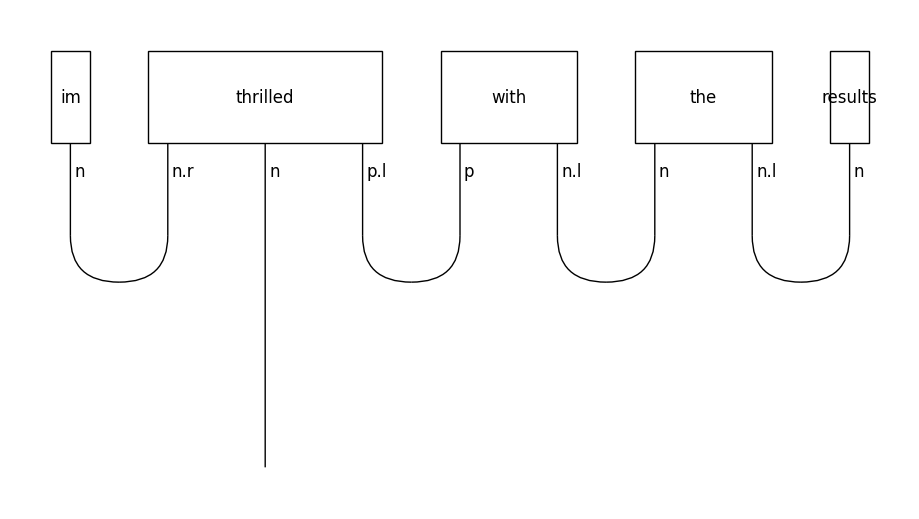

In [179]:
train_diagrams_filter[10].normal_form().draw(figsize=(9, 5), fontsize=12)

In [180]:
from lambeq import AtomicType, IQPAnsatz, SpiderAnsatz, RemoveCupsRewriter

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE

# Create an ansatz (IQPAnsatz in this example)
ansatz = IQPAnsatz({noun: 2, sentence_type: 1},n_layers=1,n_single_qubit_params=5)

remove_cups = RemoveCupsRewriter()

train_circuits = []
test_circuits =  []


for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Train diagram",index)
        train_labels[index] = None

for index,d in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Test diagram",index)
        test_labels[index] = None



#train_circuits[0].draw(figsize=(9, 10))

Problem with Train diagram 0
Problem with Train diagram 5
Problem with Train diagram 10
Problem with Train diagram 18
Problem with Train diagram 43
Problem with Train diagram 49
Problem with Train diagram 56
Problem with Train diagram 64
Problem with Train diagram 75
Problem with Train diagram 79
Problem with Train diagram 82


In [181]:
train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [182]:
print("Number of Train circuits", len(train_circuits), "and labels", len(train_labels), "match? ->", len(train_circuits) == len(train_labels))
print("Number of Test circuits", len(test_circuits), "and labels", len(test_labels), "match? ->", len(test_circuits) == len(test_labels))

Number of Train circuits 74 and labels 74 match? -> True
Number of Test circuits 32 and labels 32 match? -> True


In [183]:
"""
train_diagrams_filter[7].draw(figsize=(9, 1.5))
train_diagrams_filter[43].draw()
train_diagrams_filter[51].draw()
"""

'\ntrain_diagrams_filter[7].draw(figsize=(9, 1.5))\ntrain_diagrams_filter[43].draw()\ntrain_diagrams_filter[51].draw()\n'

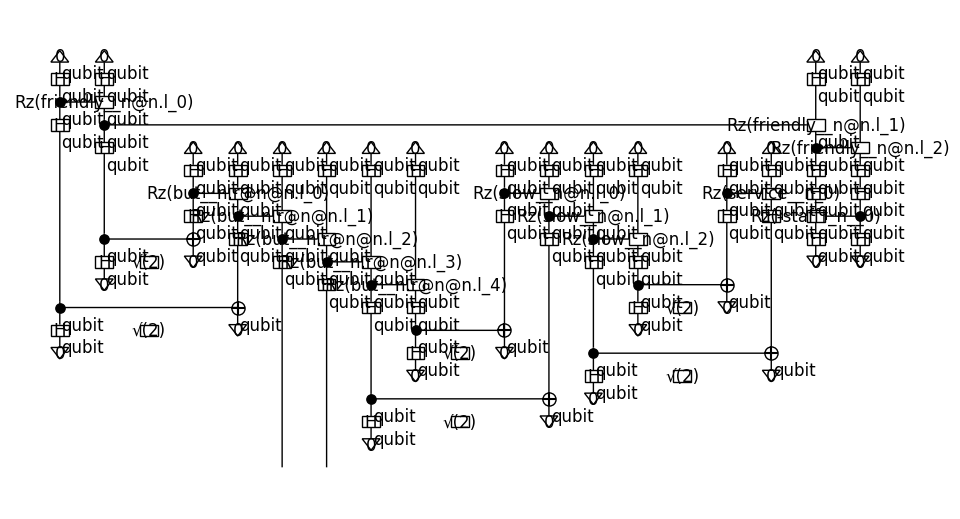

In [184]:
train_circuits[2].draw(figsize=(9, 5), fontsize=12)

In [185]:
# TESTING

'''
# Parse a sentence into a diagram
parser = BobcatParser(verbose='text')
sentence = "This is a simple example."
ccg_diagram = parser.sentence2diagram(sentence)

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE

# Create an ansatz (IQPAnsatz in this example)
ansatz = IQPAnsatz({noun: 2, sentence_type: 1},n_layers=1,n_single_qubit_params=3)

# Convert the CCG diagram into a quantum circuit
circuit = ansatz(train_diagrams_filter[0])

# Now `circuit` is a pytket circuit ready for simulation or running on a quantum computer
circuit.draw()
'''

'\n# Parse a sentence into a diagram\nparser = BobcatParser(verbose=\'text\')\nsentence = "This is a simple example."\nccg_diagram = parser.sentence2diagram(sentence)\n\n# Define types for the ansatz\nnoun = AtomicType.NOUN\nsentence_type = AtomicType.SENTENCE\n\n# Create an ansatz (IQPAnsatz in this example)\nansatz = IQPAnsatz({noun: 2, sentence_type: 1},n_layers=1,n_single_qubit_params=3)\n\n# Convert the CCG diagram into a quantum circuit\ncircuit = ansatz(train_diagrams_filter[0])\n\n# Now `circuit` is a pytket circuit ready for simulation or running on a quantum computer\ncircuit.draw()\n'

In [189]:
# Testing with SpiderAnsatz

"""
from lambeq.backend.tensor import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

remove_cups = RemoveCupsRewriter()

train_circuits = []
test_circuits =  []


for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Train diagram",index)
        train_labels[index] = None

for index,d in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Test diagram",index)
        test_labels[index] = None
"""

'\nfrom lambeq.backend.tensor import Dim\n\nfrom lambeq import AtomicType, SpiderAnsatz\n\nansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),\n                       AtomicType.SENTENCE: Dim(2)})\n\nremove_cups = RemoveCupsRewriter()\n\ntrain_circuits = []\ntest_circuits =  []\n\n\nfor index, diag in enumerate(train_diagrams_filter):\n    try:\n        train_circuits.append(ansatz(remove_cups(diag)))\n    except Exception as e:\n        print("Problem with Train diagram",index)\n        train_labels[index] = None\n\nfor index,d in enumerate(test_diagrams_filter):\n    try:\n        test_circuits.append(ansatz(remove_cups(diag)))\n    except Exception as e:\n        print("Problem with Test diagram",index)\n        test_labels[index] = None\n'

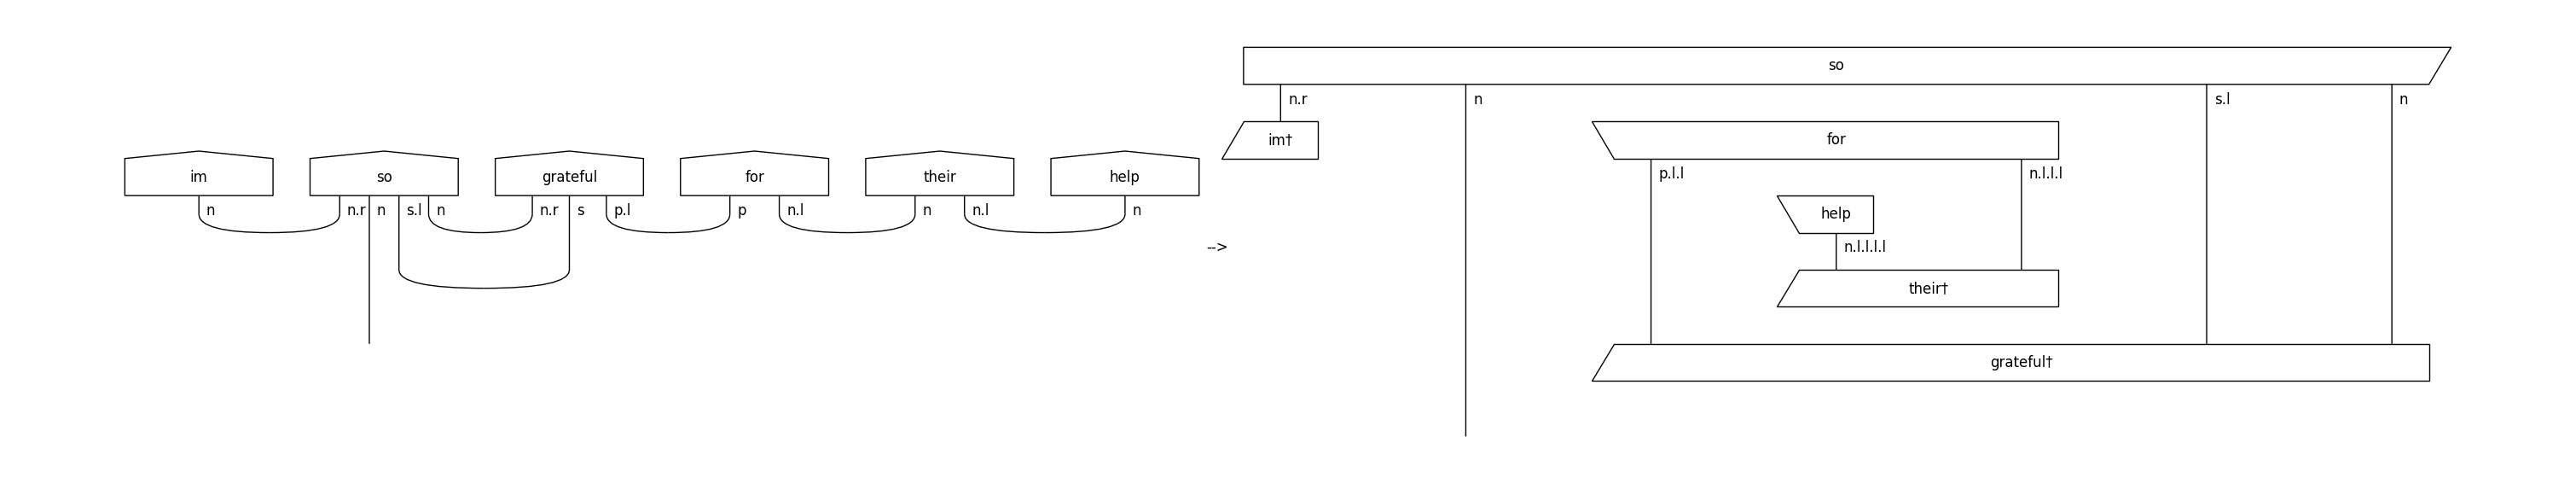

In [187]:
from lambeq.backend import draw_equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

draw_equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(30, 6), asymmetry=0.3, fontsize=12)

## Training

In [203]:
sig = torch.sigmoid
def accuracy(y_pred, y_true):
    y_pred = sig(y_pred)
    y_pred = torch.round(y_pred)
    return torch.sum(y_pred == y_true).item() / len(y_true)

eval_metrics = {"accuracy": accuracy}

In [204]:
BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0


In [205]:
from lambeq import PytorchModel

all_circuits = train_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

In [209]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model.circuit,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

AttributeError: 'PytorchModel' object has no attribute 'circuit'